In [9]:
import json
import sys
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [10]:
DIR = "/home/claudio/hdd/git/bachelorThesis/figure_8/"

In [11]:
def read_json(cluster, filetype, read_ab, read_cd, read_ef):
    jsondata = None
    with open(DIR + cluster + "_figure8" + filetype + ".json", "r") as f:
        jsondata = json.loads(f.read())
    
    terms = ["-1","4","5","6","7","8"]
    intervals = range(0, 41)
    
    cd_measures = [0, 0.2, 0.4, 0.6, 0.8, 1]
    measures = set()
    if read_ab:
        measures.add('rcpu')
        measures.add('rram')
    if read_ef:
        measures.add('ucpu')
        measures.add('uram')
    
    dfd = {'term': [], 'measure': [], 'interval': [], 'count': []}
    
    for t in terms:
        for m in measures:
            if jsondata[t][m] is None:
                continue
            for i in intervals:
                dfd["term"].append(int(t))
                dfd["measure"].append(m)
                dfd["interval"].append(i / 40)
                dfd["count"].append(jsondata[t][m][i])
        if read_cd:
            for m in ["rscpu", "rsram"]:
                if jsondata[m][t] is None:
                    continue
                for i, mi in enumerate(cd_measures):
                    dfd["term"].append(int(t))
                    dfd["measure"].append(m)
                    dfd["interval"].append(mi)
                    if len(jsondata[m][t]) == 41 and i != 0:
                        dfd["count"].append([sum(jsondata[m][t][k]) for k in range(i, i+8)])
                    else:
                        dfd["count"].append(jsondata[m][t][i])

    return pd.DataFrame(dfd, columns=dfd.keys())

dfs = {}

dfs["a"] = pd.concat([read_json("a", "abef", True, False, True), read_json("a", "", False, True, False)])
for c in "bcd":
    dfs[c] = read_json(c, "abef", True, False, True)
for c in "efgh":
    dfs[c] = read_json(c, "ab", True, False, False)   

In [31]:
def categorical_plot(df, key, title, sorted_xs = None):
    if sorted_xs == None:
        xs = set()
        lines = []
        for t in [4,5,6,7,8]:
            xs = xs.union(np.array(df[df.term == t][key]).reshape(-1))
        xs = [str(x) for x in sorted(xs)]
    else:
        xs = sorted_xs
        
    plt.figure(figsize=(25,8))
    ax = plt.gca()
    lines = []
    for t in [4,5,6,7,8]:
        ys = []
        for x in xs:
            partsum = df[(df.term != -1) & (df[key] == float(x))]["count"].sum().astype(int)
            y = df[(df.term == t) & (df[key] == float(x))]["count"]
            ys.append((y.values.astype(int)[0] / partsum if partsum > 0 else y.values.astype(int)[0]) if y.any() else 0)
        lines.append(ax.plot(xs,ys, marker='.')[0])

    plt.xticks(xs)
    plt.legend(lines, ["EVICT", "FAIL", "FINISH", "KILL", "LOST"],
              bbox_to_anchor=(1,1))
    plt.title(title)
    plt.show()

In [36]:
def prepare_plot(cluster, measure):
    titles = {
        "rscpu": "CPU reservation w.r.t. event rate",
        "rsram": "Memory reservation w.r.t. event rate",
        "rcpu": "CPU request w.r.t. event rate",
        "rram": "Memory request w.r.t. event rate",
        "ucpu": "CPU utilization w.r.t. event rate",
        "uram": "Memory utilization w.r.t. event rate",
    }
    
    df = dfs[cluster]
    df = df[df.measure == measure]
    del df["measure"]
    df = df.sort_values(["term", "interval"])
    
    
    categorical_plot(df, "interval", titles[measure] + " (cluster " + cluster + ")")

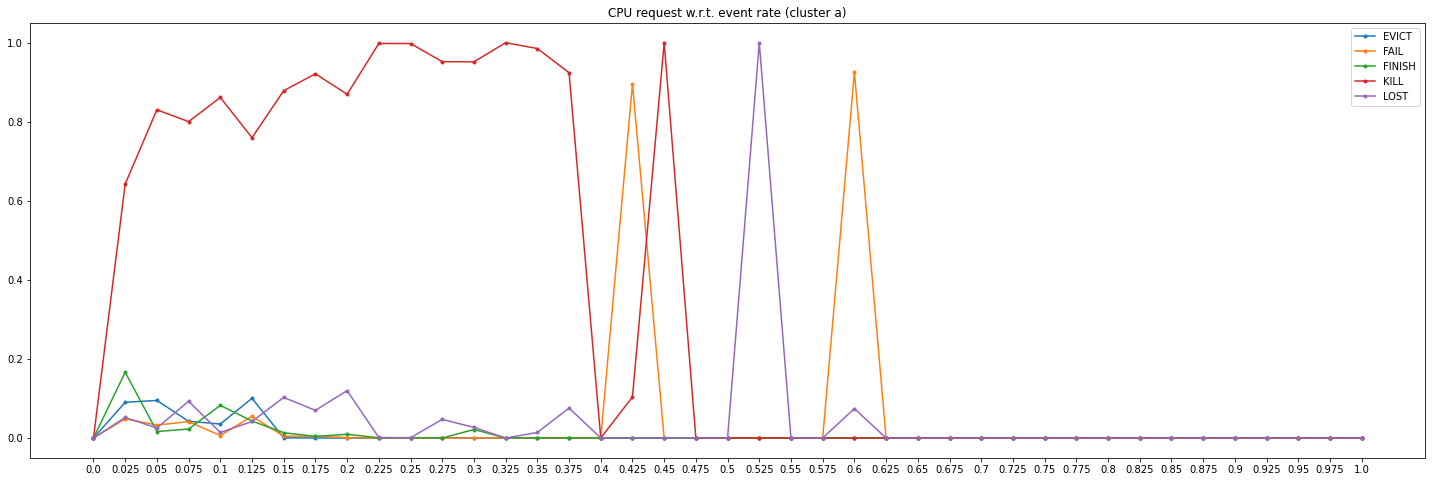

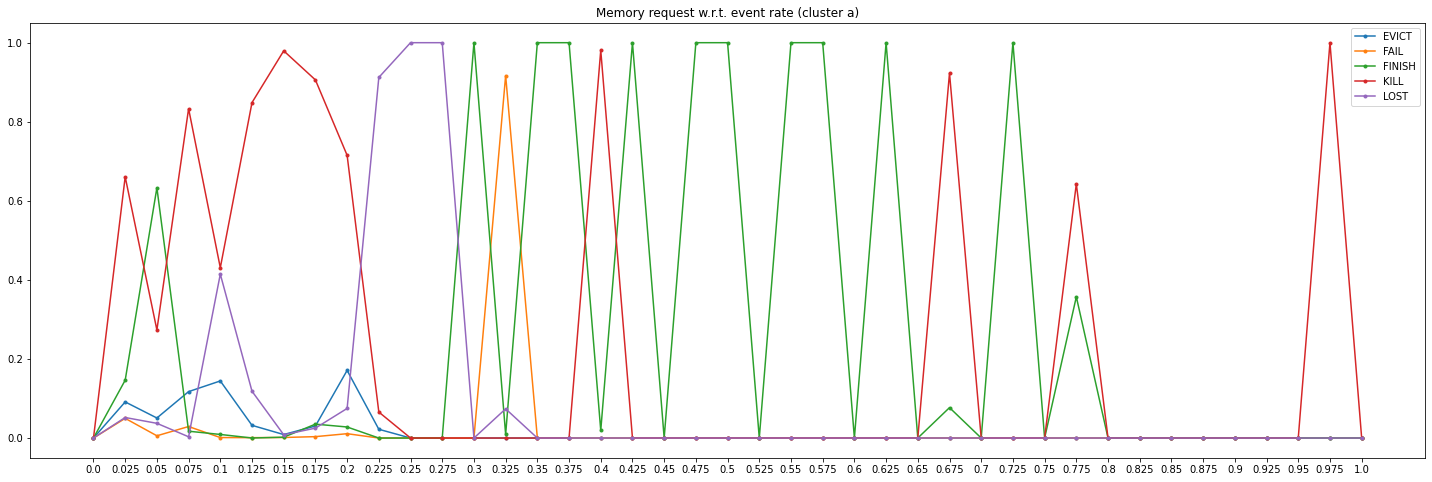

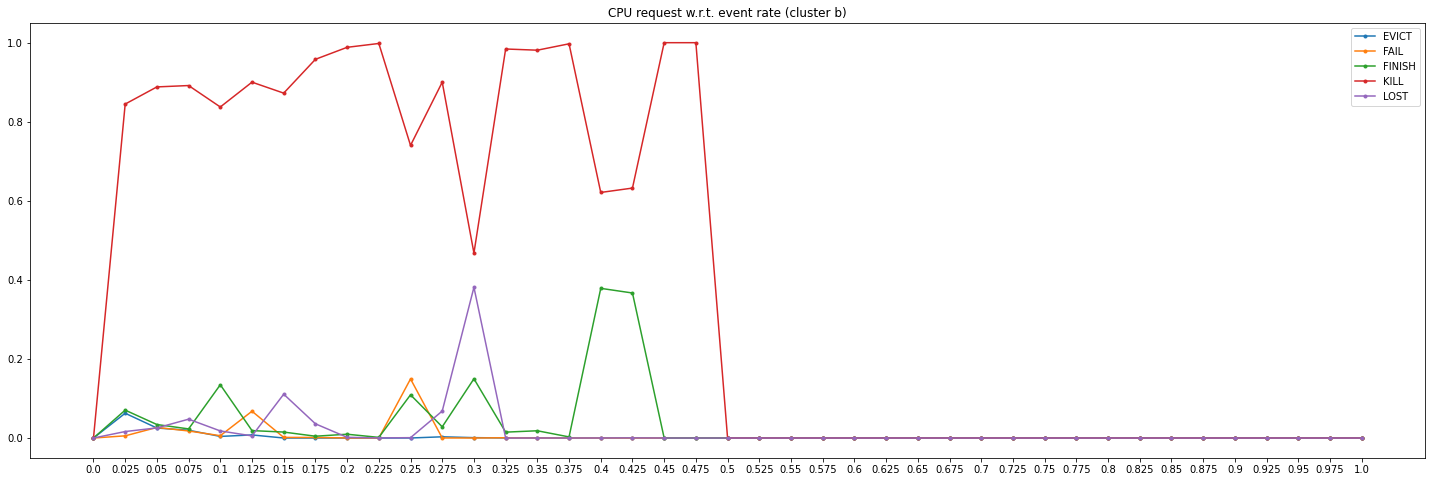

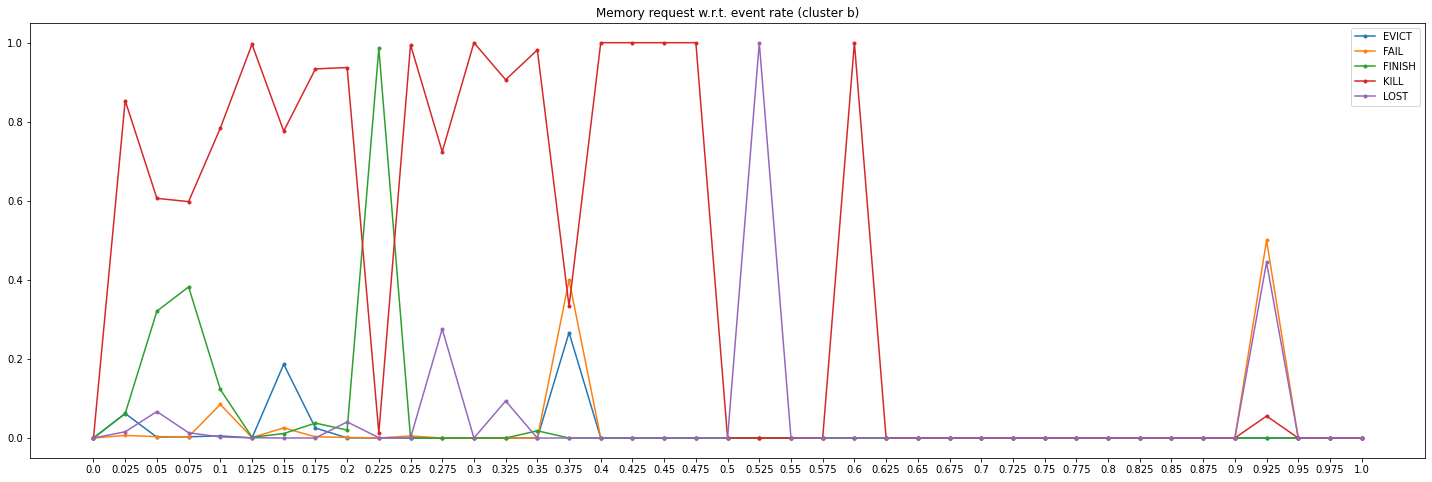

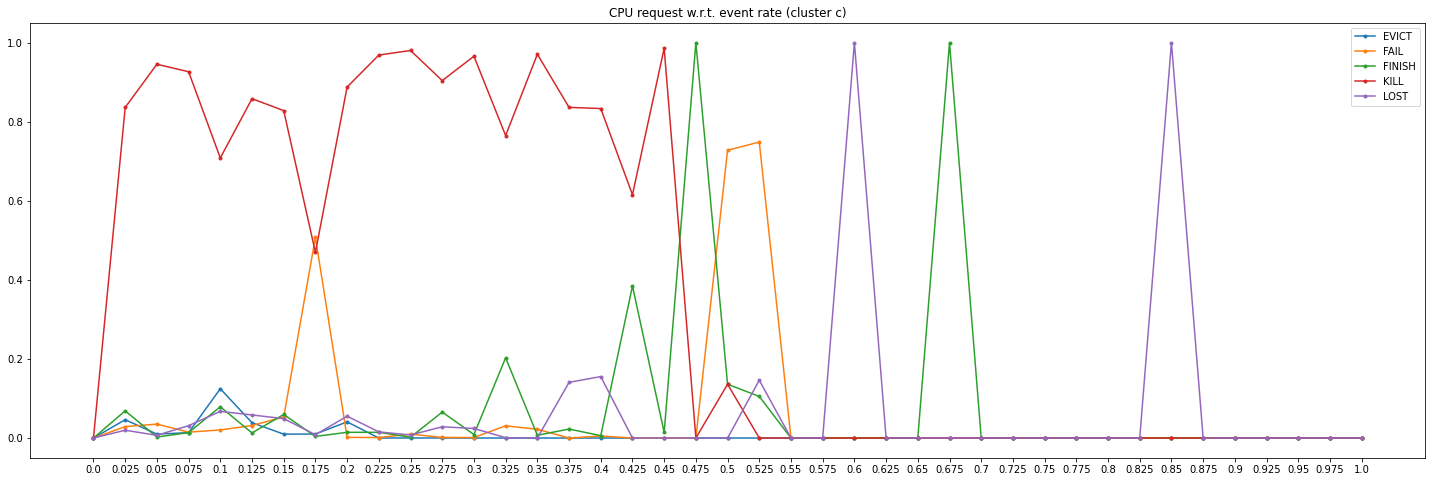

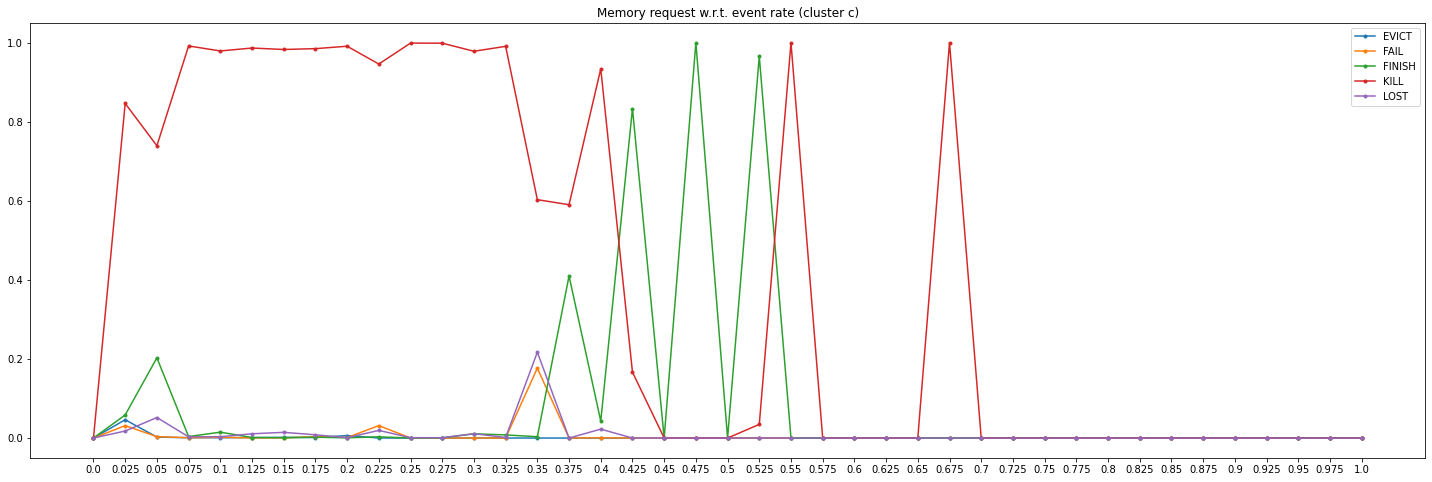

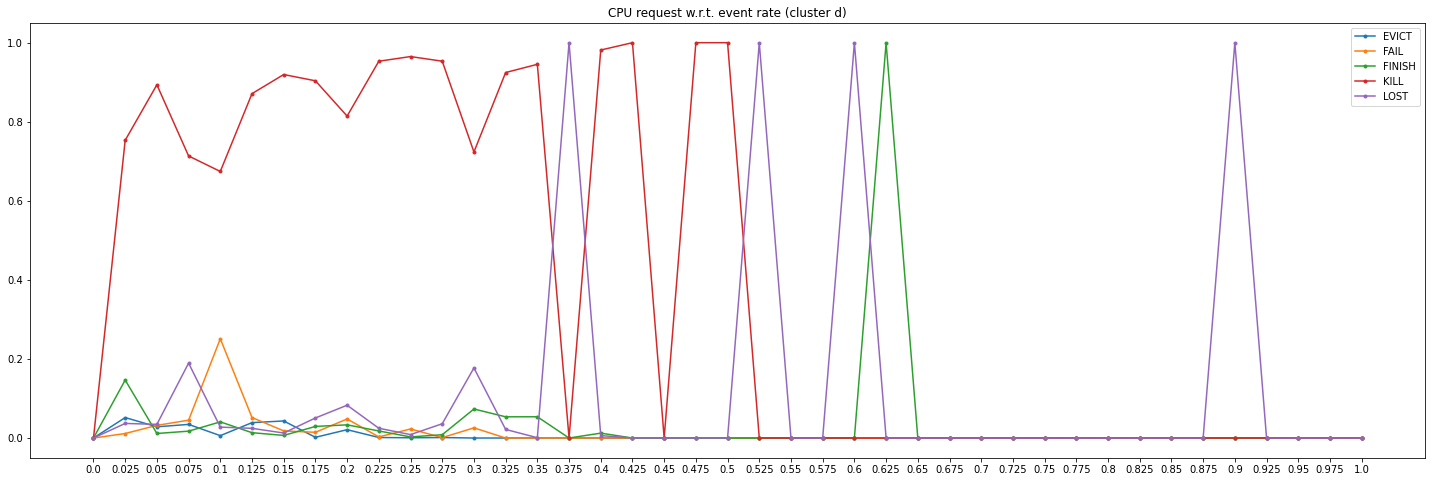

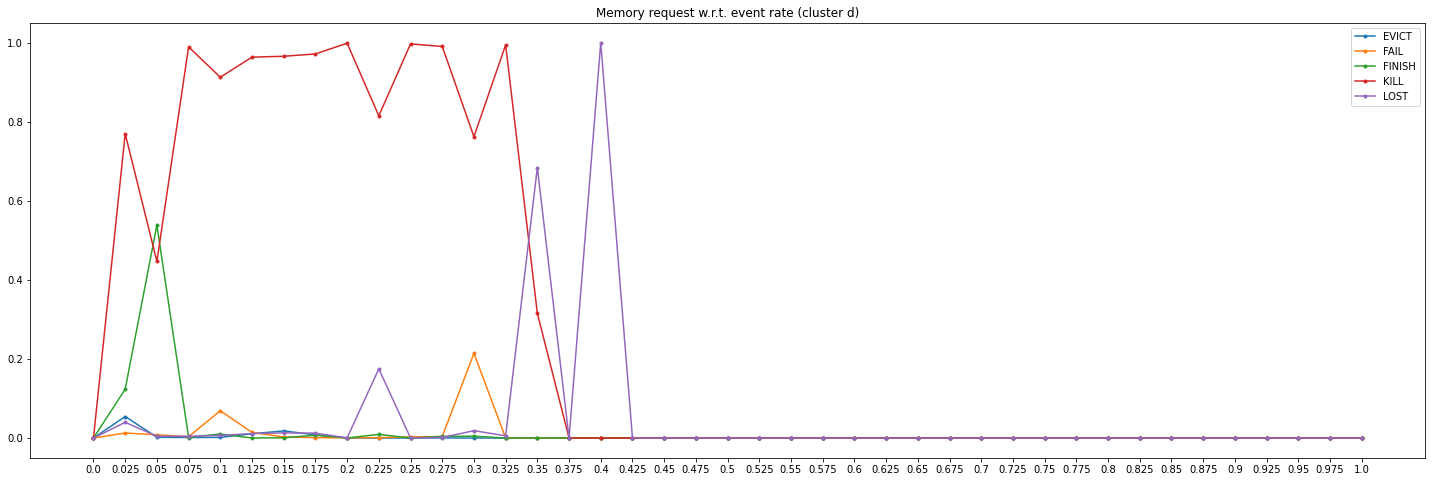

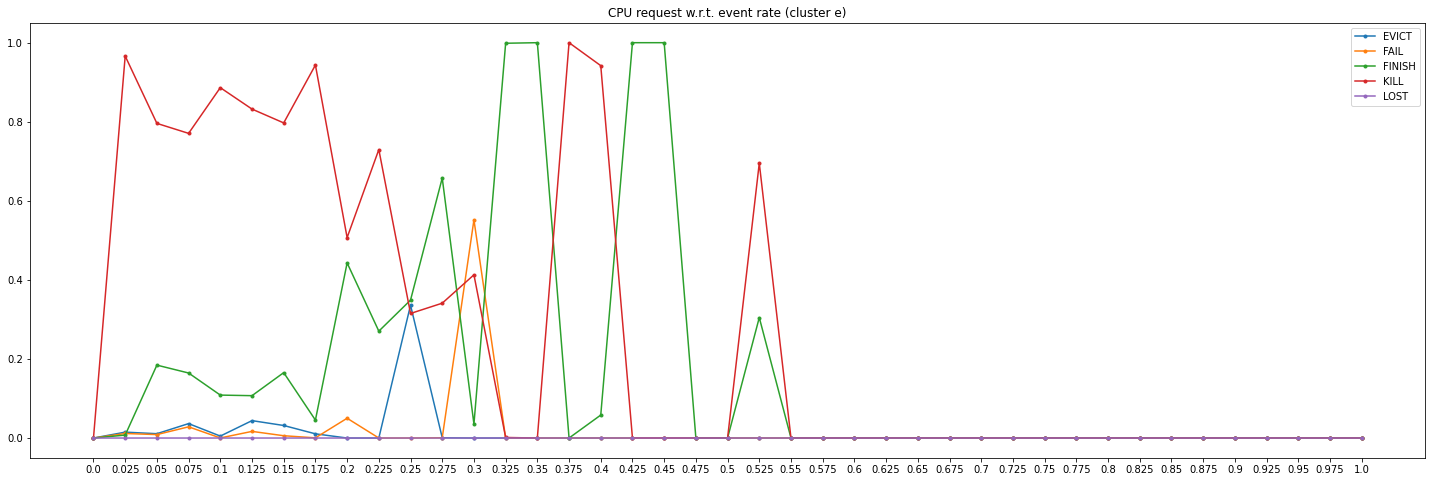

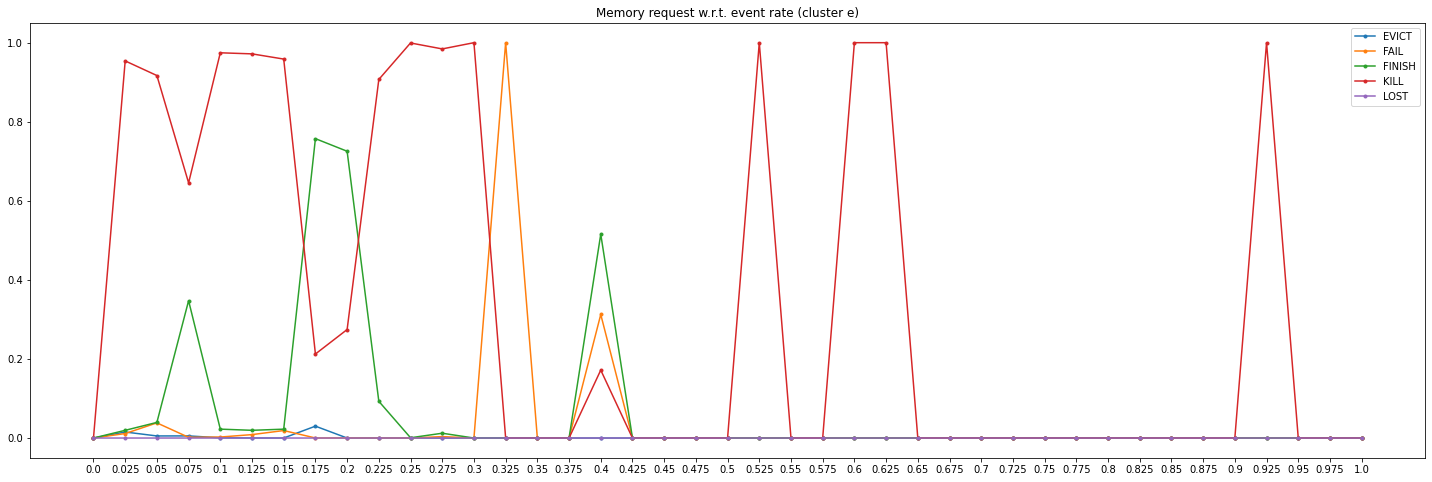

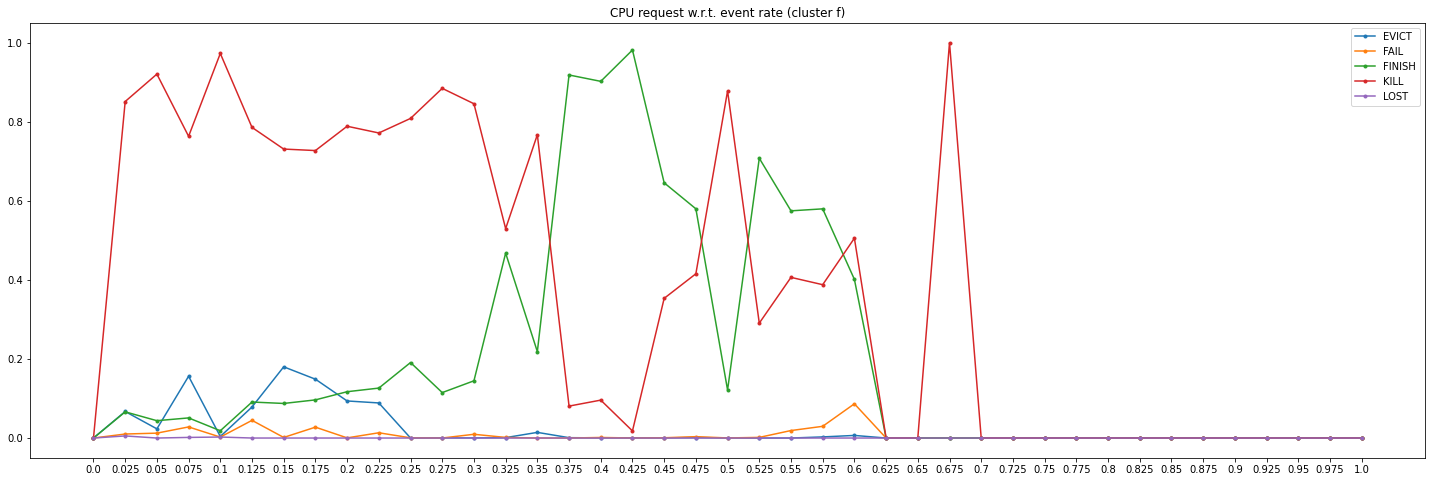

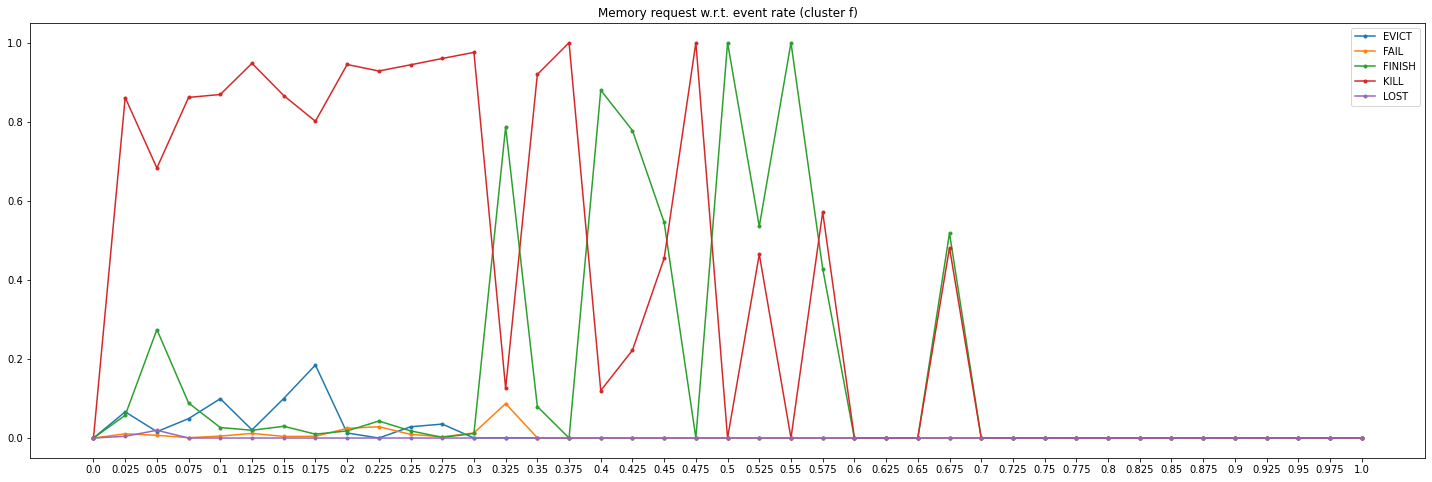

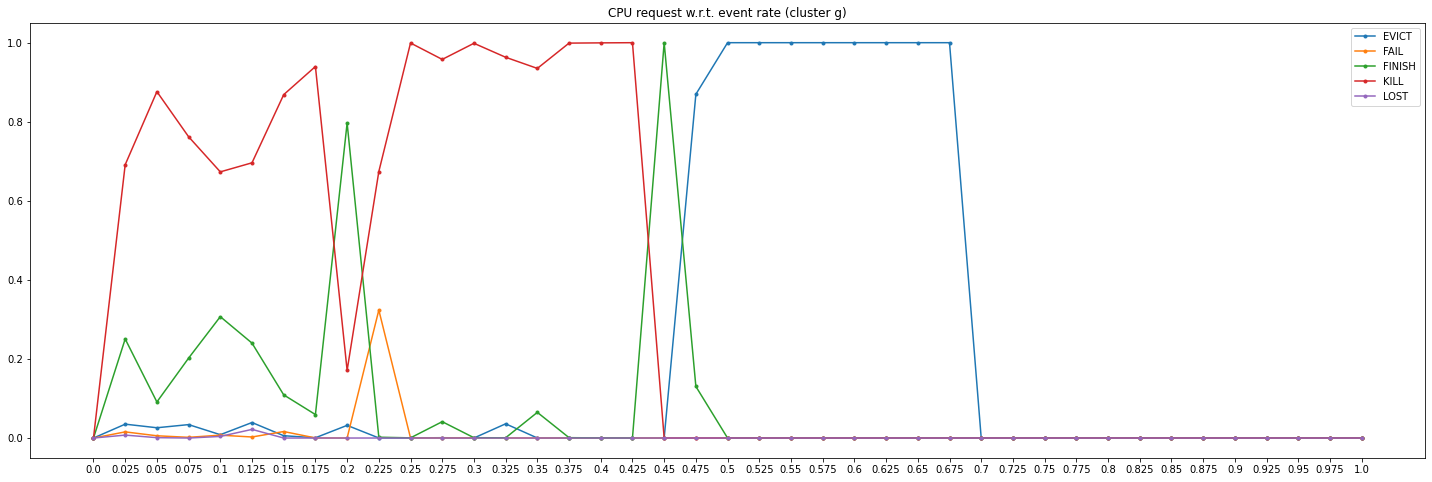

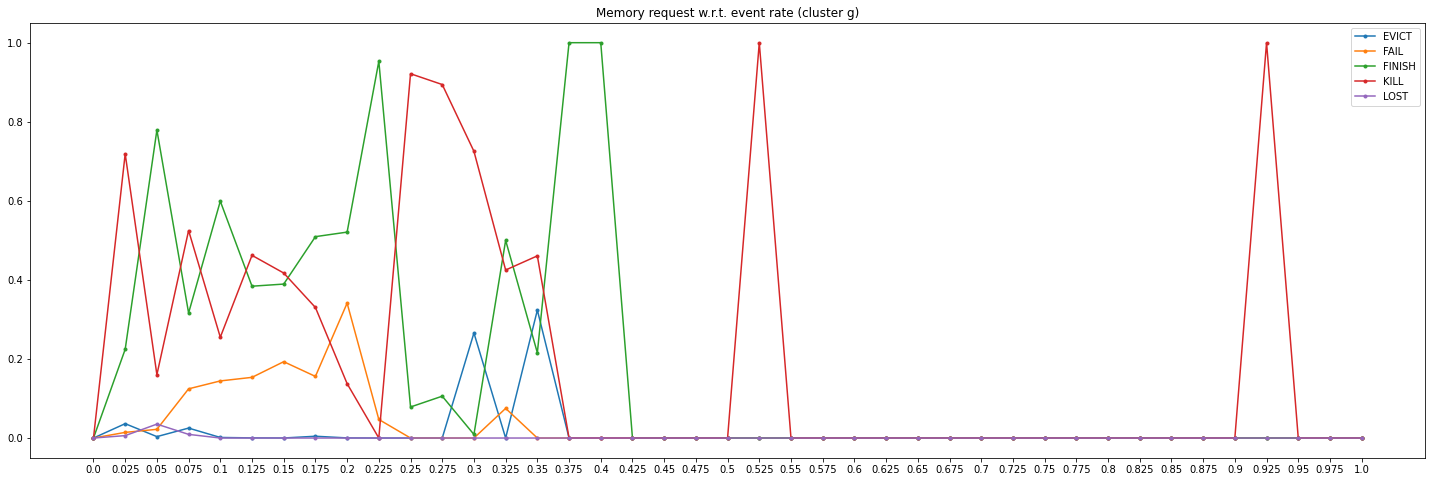

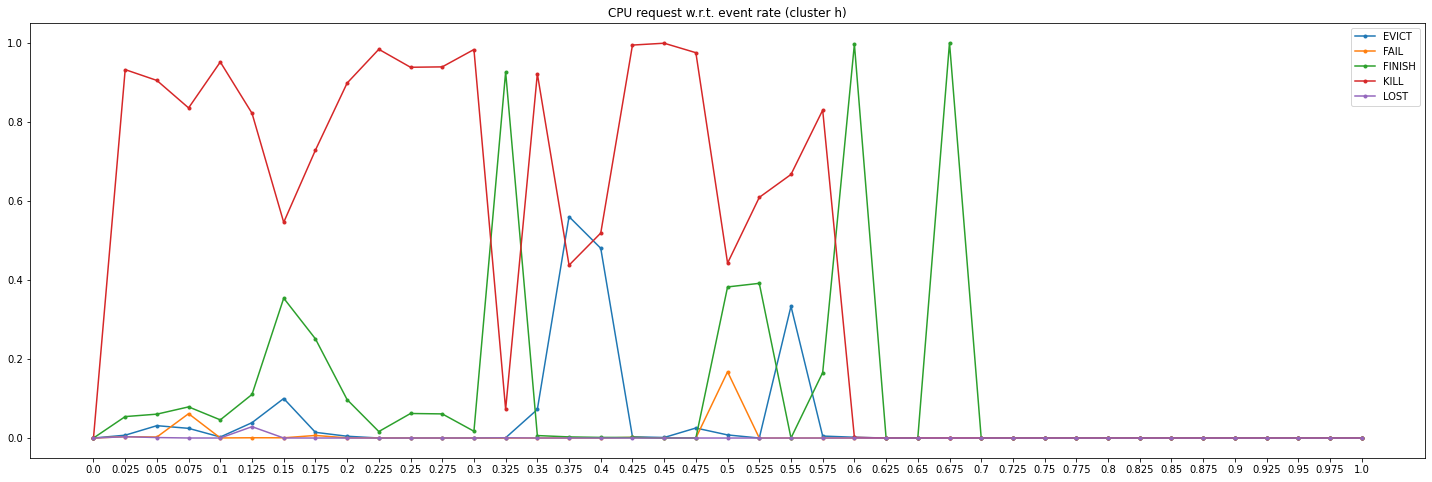

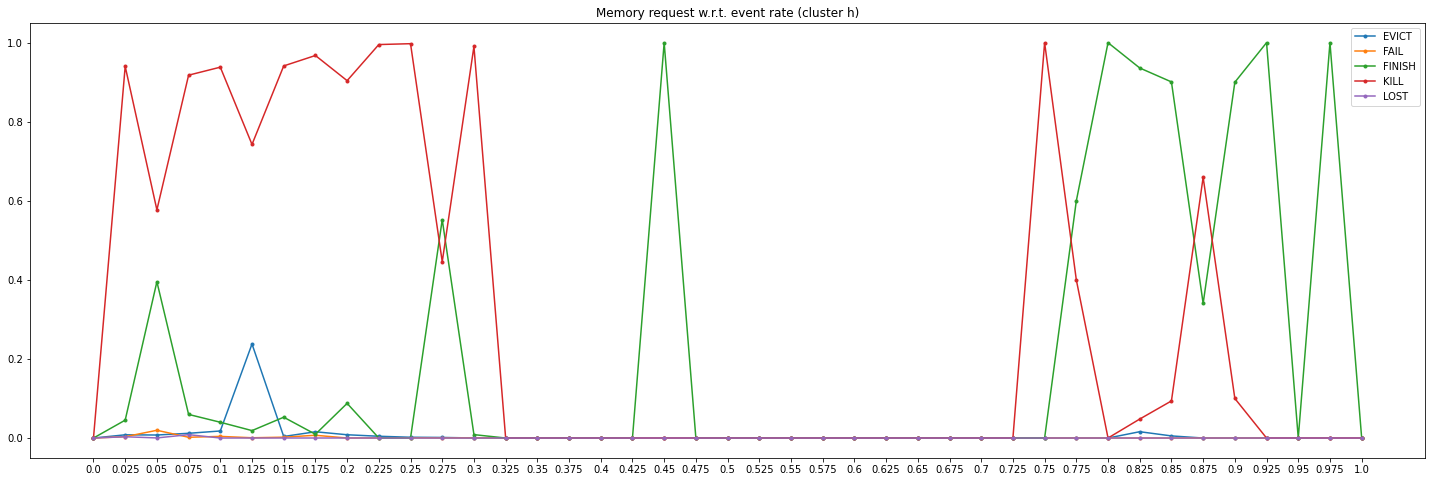

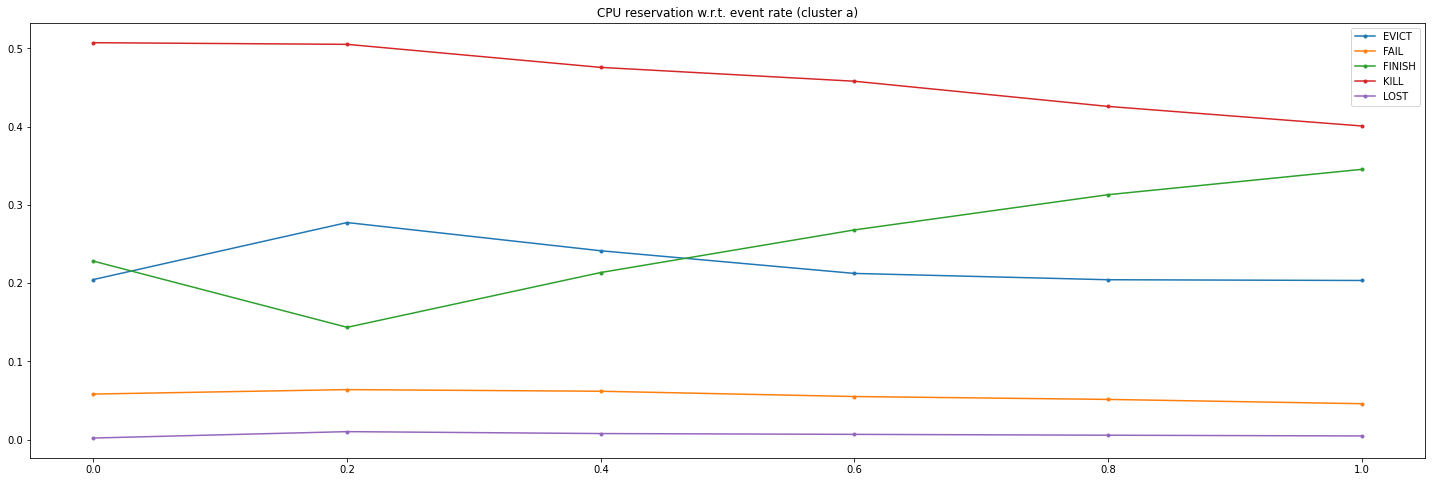

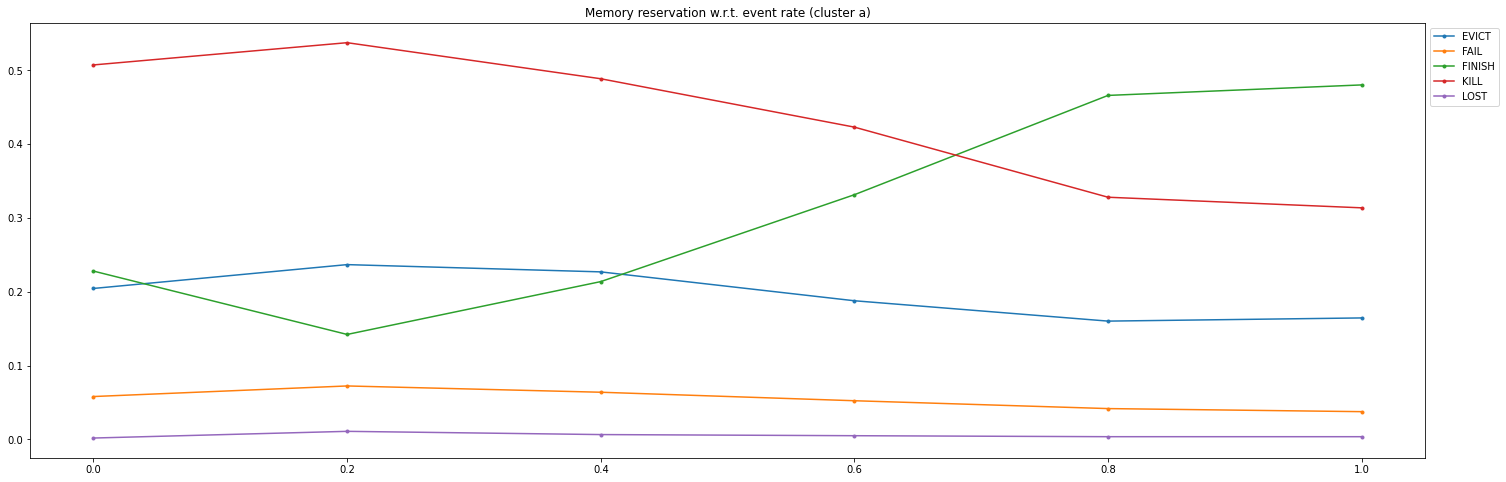

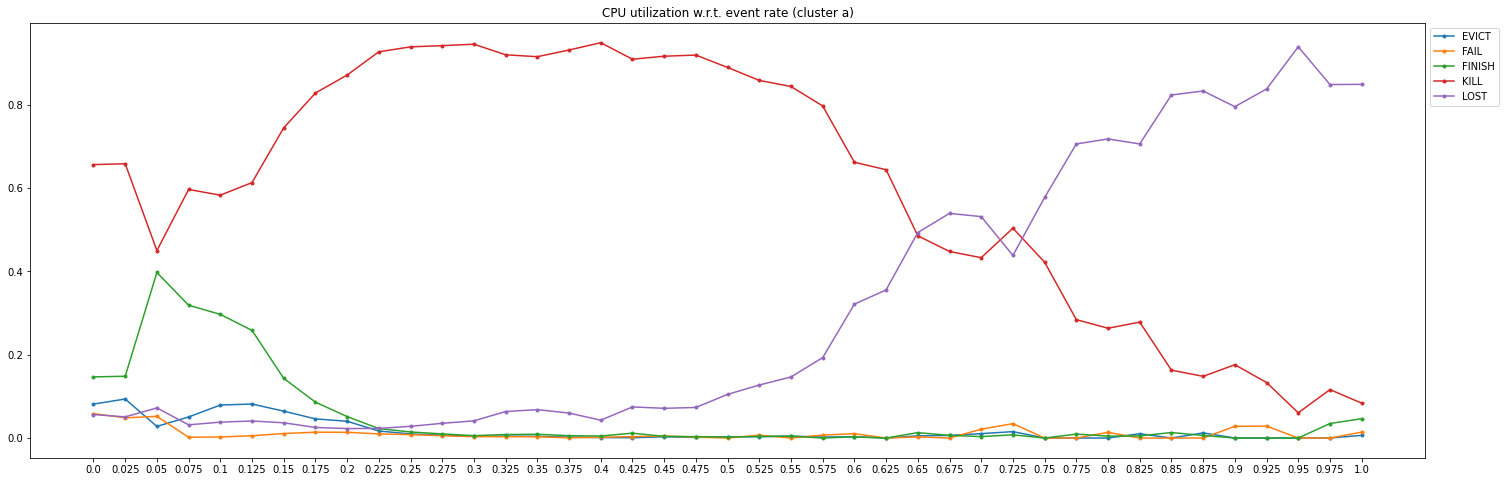

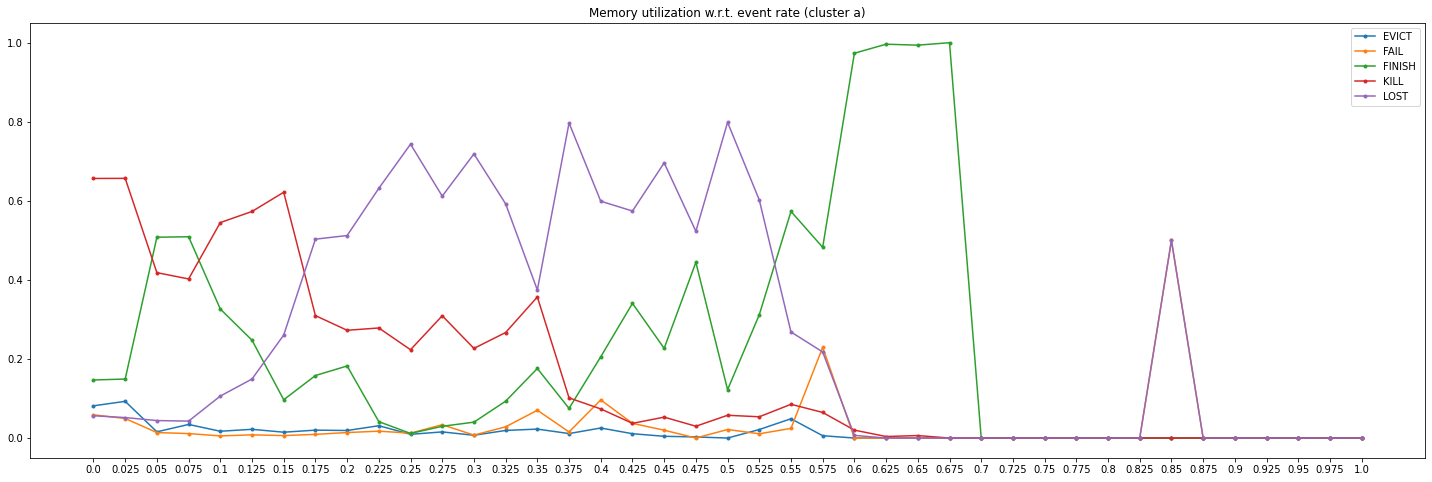

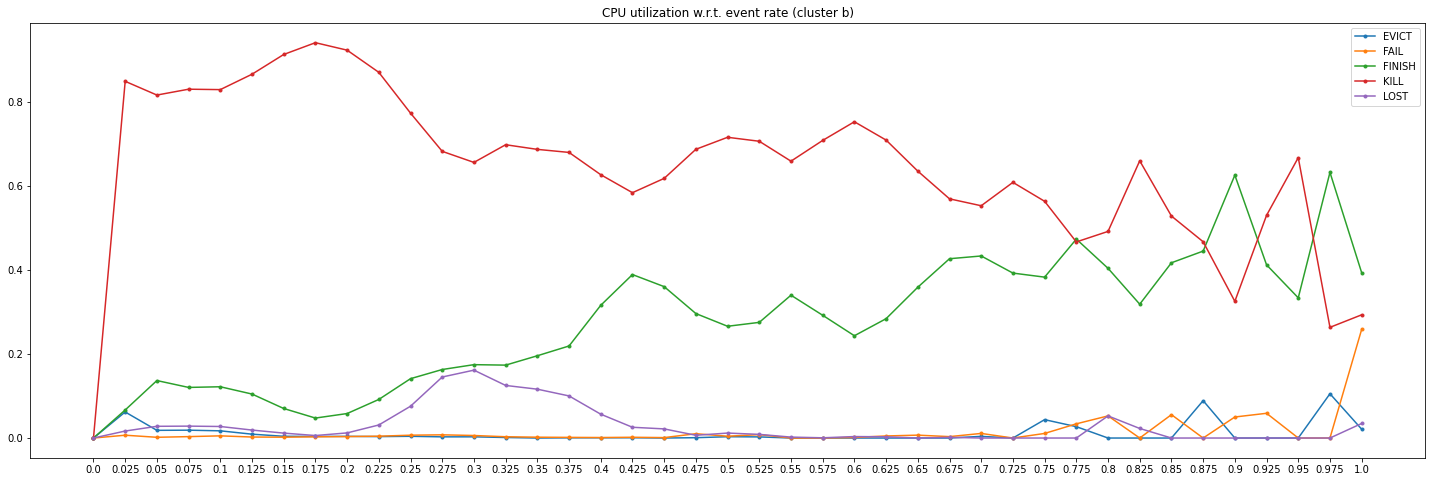

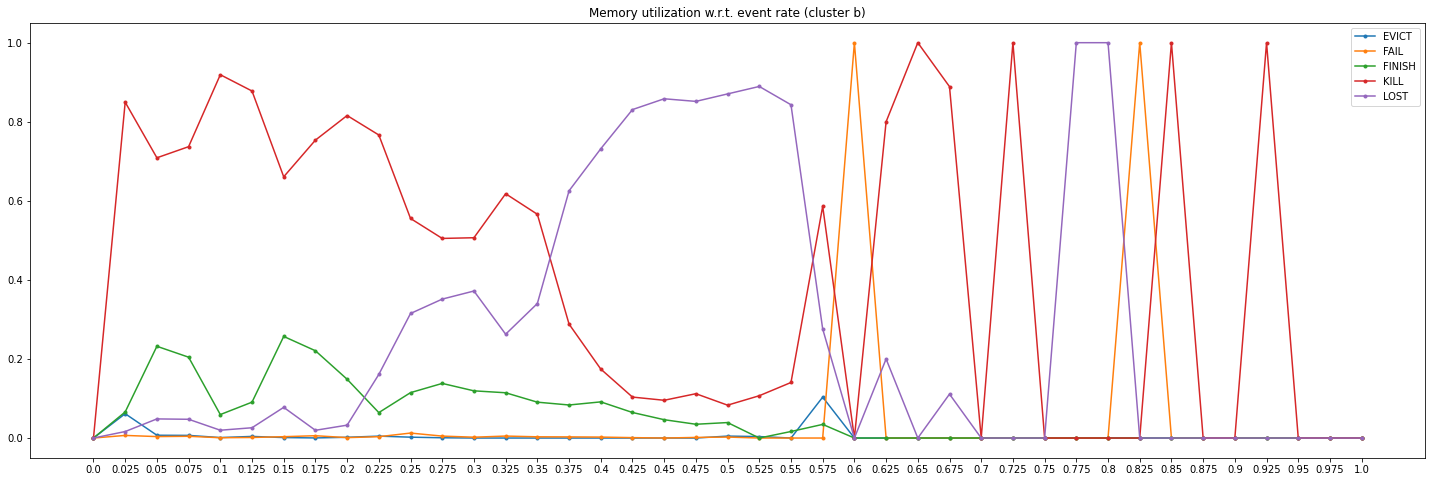

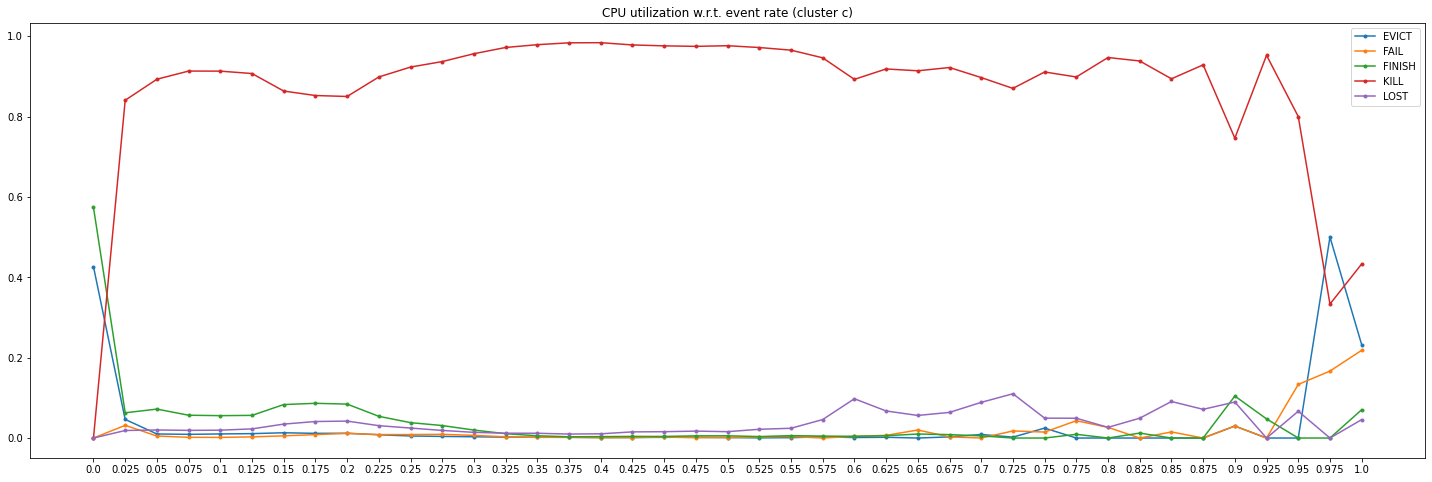

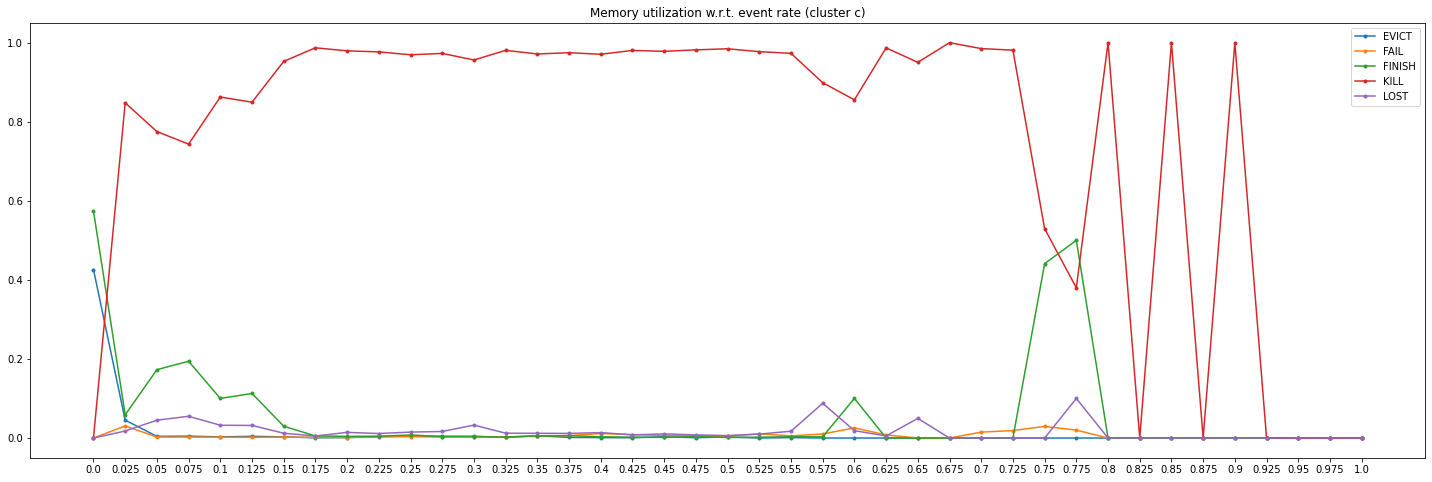

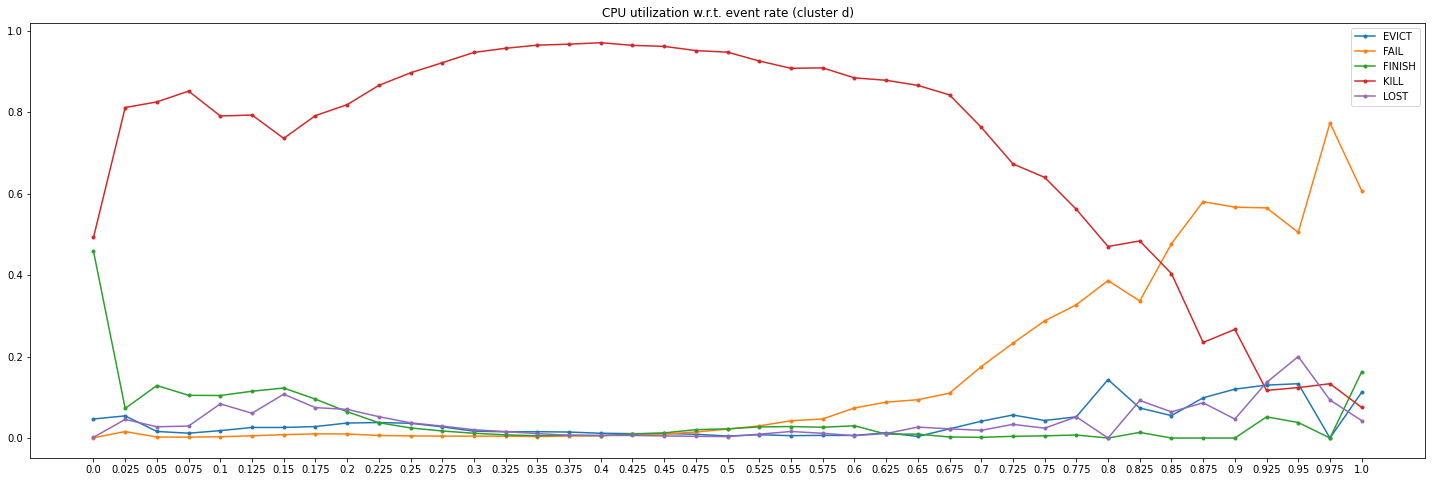

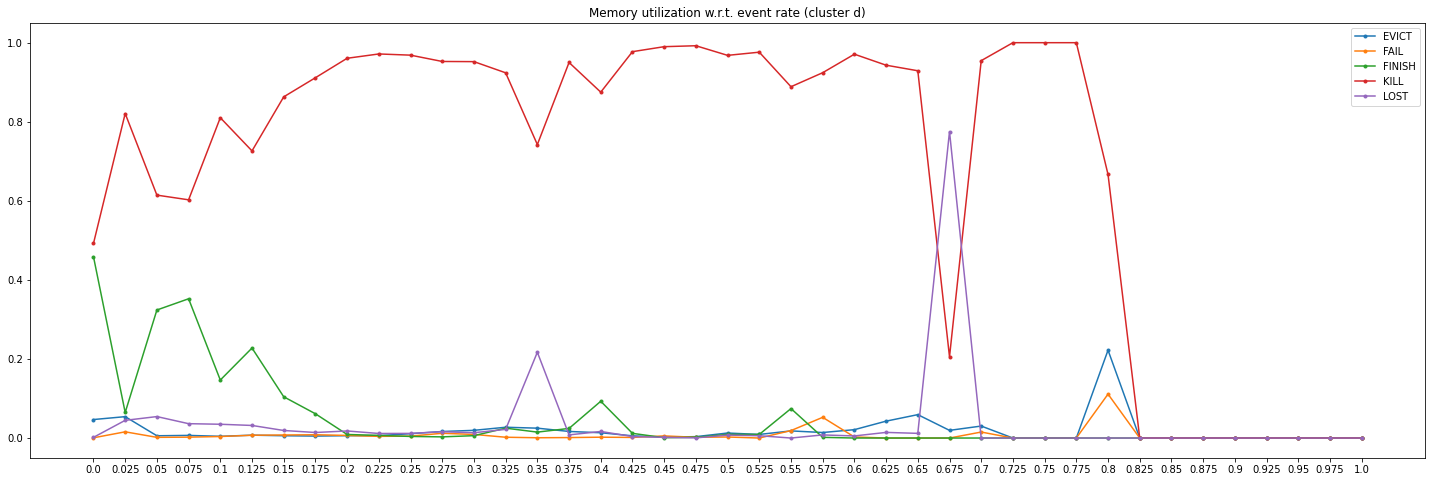

In [37]:
for cluster in "abcdefgh":
    prepare_plot(cluster, "rcpu")
    prepare_plot(cluster, "rram")
prepare_plot("a", "rscpu")
prepare_plot("a", "rsram")
for cluster in "abcd":
    prepare_plot(cluster, "ucpu")
    prepare_plot(cluster, "uram")